# Анализ мобильного приложения

Целью проекта является изучение мобильного приложения стартапа, который продает продукты питания. Работа состоит из двух основных частей: анализ воронки событий для исследования поведения пользователей (пол логам действий пользователей), а также изучение A/A/B-теста, задачей которого являлось выявление эффективности нового шрифта в приложении. 

## Содержание <a id='contents'></a>
1. [Загрузка и подготовка данных](#prepair)
2. [Исследовательский анализ данных](#eda)
3. [Изучение воронки событий](#funnel)
4. [Анализ результатов A/A/B-эксперимента](#aab)
    * [A. Сравнение контрольных выборок](#aa)
    * [B. Сравнение тестовой и контрольных групп](#ab)
5. [Общий вывод](#conclusion)

## 1. Загрузка и подготовка данных <a id='prepair'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from warnings import filterwarnings
from IPython.display import display

filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

In [2]:
df = pd.read_csv(r'logs_exp.csv', sep='\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.shape

(244126, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [6]:
f'Число полных дубликатов: {df.duplicated().sum()}, \
доля полных дубликатов: {df.duplicated().sum() / len(df):.2%}'

'Число полных дубликатов: 413, доля полных дубликатов: 0.17%'

План предобработки:  
1. Заменить названия столбцов на более удобные и значения в столбце *ExpId* на более "говорящие".  
2. Изменить типы данных в столбцах *DeviceIDHash* и *ExpId* на `object`.  
3. Удалить дубликаты. Скорее всего, они возникли из-за технического сбоя при записи логов: едва ли один и тот же пользователь мог сделать одно и то же действие в одну и ту же секунду (на это можно обратить внимание технических специалистов). При этом число дубликатов невелико, их удаление не окажет существенного влияния на качество анализа.  
4. На основе временных меток в столбце *EventTimestamp* (даны в секундах от первого января 1970 года) сосздать столбец с датой и временем операции и отдельный столбец с датой.

In [7]:
columns = {
    'EventName': 'event',
    'DeviceIDHash': 'uid',
    'ExpId': 'group',
    'EventTimestamp': 'datetime'
}
df = df.rename(columns=columns)

In [8]:
df['group'] = df['group'].apply(lambda x: 'A1' if x == 246 else ('A2' if x == 247 else 'B'))

df['uid'] = df['uid'].astype(str)

df = df.drop_duplicates().reset_index(drop=True)

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')
df['date'] = pd.to_datetime(df['datetime'].dt.date)

In [10]:
df.head()

,event,uid,datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     243713 non-null  object        
 1   uid       243713 non-null  object        
 2   datetime  243713 non-null  datetime64[ns]
 3   group     243713 non-null  object        
 4   date      243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 9.3+ MB


### Вывод

Таблица содержит 243 713 записей об отдельных событиях, для каждого из которых мы знаем тип, ID пользователя, который совершил то или иное действие, дату и время, когда оно произошло, а также то, к какой из трех экпериментальных групп относился пользователь. Пропусков в таблице нет, повторы удалены, типы данных приведены к нужным.

[Наверх](#contents)

## 2. Исследовательский анализ данных <a id='eda'></a>

In [12]:
print('Уникальные события в логе:', ', '.join(df.event.unique()))
print(f'Всего уникальных событий: {df.event.nunique()}')

Уникальные события в логе: MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, Tutorial
Всего уникальных событий: 5


In [13]:
print(f'Всего уникальных пользователей: {df.uid.nunique()}')

Всего уникальных пользователей: 7551


In [14]:
print(f'Общее число событий: {len(df)}')
print('Среднее число событий на одного пользователя:', f'{len(df) / df.uid.nunique():.0f}')

Общее число событий: 243713
Среднее число событий на одного пользователя: 32


In [15]:
print(f'Период наблюдений: {df.datetime.min()} - {df.datetime.max()}')
print(f'Всего дней: {(df.datetime.max() - df.datetime.min()).ceil("d").days}')

Период наблюдений: 2019-07-25 04:43:36 - 2019-08-07 21:15:17
Всего дней: 14


Рассмотрим распределение данных во времени: сгруппируем число пользователей, число уникальных пользователей и число событий по дням, а затем построим соответствующие графики.

In [16]:
df_grouped_by_day = df.groupby('date', as_index=False)\
                        .agg({'uid': 'nunique', 'event': 'count'})
df_grouped_by_day.columns = ['date', 'uid_unique', 'event_cnt']

In [17]:
df_grouped_by_day

,date,uid_unique,event_cnt
0,2019-07-25,7,9
1,2019-07-26,22,31
2,2019-07-27,39,55
3,2019-07-28,69,105
4,2019-07-29,135,184
5,2019-07-30,296,412
6,2019-07-31,924,2030
7,2019-08-01,3703,36141
8,2019-08-02,3647,35554
9,2019-08-03,3482,33282


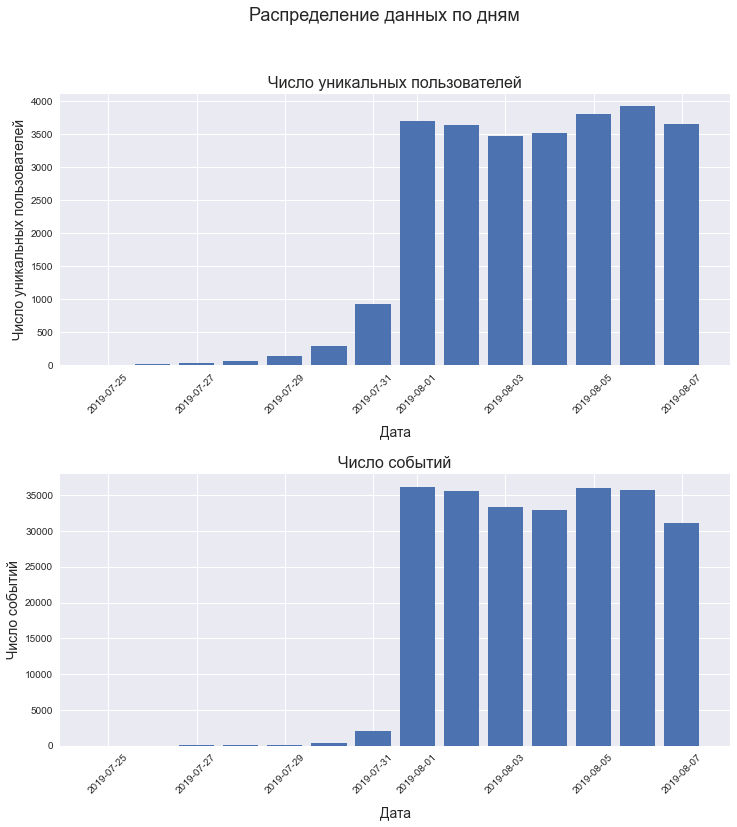

In [18]:
titles = ['Число уникальных пользователей', 'Число событий']

fig, ax = plt.subplots(2,1, figsize=(12, 12))
fig.suptitle('Распределение данных по дням')
plt.subplots_adjust(hspace=0.4)
for i in range(2):
    ax[i].bar(x=df_grouped_by_day['date'], height=df_grouped_by_day.iloc[:, i+1])
    ax[i].set_title(titles[i])
    ax[i].set_xlabel('Дата', labelpad=10)
    ax[i].set_ylabel(titles[i])
    plt.setp(ax[i].get_xticklabels(), rotation=45)
plt.show()

Как видно по этому графику, число уникальных пользователей, попавших в логи, а также число событий очень мало для первых семи дней периода и резко возрастает после 1 августа. По-видимому, данные до этого дня не полны, поэтому мы не можем считать их репрезентативными. Поэтому данные за первую неделю периода придется исключить из рассмотрения. Оценим потери.

In [19]:
df_good = df[df['date'] >= '2019-08-01']
df_bad = df[df['date'] < '2019-08-01']

In [20]:
df_good.shape

(240887, 5)

In [21]:
df_good.head()

,event,uid,datetime,group,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,A1,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,A1,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,A1,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,A1,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,A2,2019-08-01


In [22]:
print(f'Отобрано записей: {len(df_good)}')
print(f'Исключено записей: {len(df_bad)}') 
print(f'Доля исключенных записей: {len(df_bad) / len(df):.2%}')

Отобрано записей: 240887
Исключено записей: 2826
Доля исключенных записей: 1.16%


In [23]:
print(f'Отобрано уникальных пользователей: {df_good.uid.nunique()}')
print(f'Исключено уникальных пользователей: {df.uid.nunique() - df_good.uid.nunique()}') 
print(f'Доля исключенных уникальных пользователей: {(df.uid.nunique() - df_good.uid.nunique()) / df.uid.nunique():.2%}')

Отобрано уникальных пользователей: 7534
Исключено уникальных пользователей: 17
Доля исключенных уникальных пользователей: 0.23%


In [24]:
print('Отобрано пользователей:')
df_good.groupby('group').agg({'uid': 'nunique'})

Отобрано пользователей:


,uid
group,
A1,2484
A2,2513
B,2537


### Вывод

1. Исходные данные содержат сведения о 243 713 событиях, относящихся к одной из пяти категорий: входы на главный экран, экран с индикацией успешной покупки, экран корзины, экран с предложениями и обучение. На основе этих данных можно построить воронку, чему будет посвящена следующая часть проекта.
2. Исходные данные охватывают период с 25 июля по 7 августа 2019 года, всего дне недели. За это время нашим приложением воспользовался 7551 уникальный пользователь, каждый из которых в среднем совершал по 32 события.
3. Распределение числа событий и уникальных пользователей по дням показывает, что данные за первую неделю неполные, а потому нерепрезентативные. Де-факто, таким образом, мы располагаем сведениями только за семь дней, однако эта выборка представляется вполне релевантной для дальнейшего анализа: сократив период вдвое, мы потеряли всего 1.16% событий и 17 (0.23%) уникальных пользователей. Среди оставшихся пользователей также сохранилось практически равное распределение пользователей по трем группам, в которых проводился тест.

[Наверх](#contents)

## 3. Изучение воронки событий <a id='funnel'></a>  

Как уже было сказано, в наших данных фигурируют события пяти видов. Для первоначального анализа рассчитаем, какие события происходят чаще всего и какие события совершают больше всего пользователей. 

In [25]:
events = df_good.groupby('event', as_index=False).agg({'uid':['count', 'nunique']})
events.columns = ['event', 'event_cnt', 'user_cnt']
events['user_share'] = events['user_cnt'] / df_good['uid'].nunique()

In [26]:
events

,event,event_cnt,user_cnt,user_share
0,CartScreenAppear,42303,3734,0.495620
1,MainScreenAppear,117328,7419,0.984736
2,OffersScreenAppear,46333,4593,0.609636
3,PaymentScreenSuccessful,33918,3539,0.469737
4,Tutorial,1005,840,0.111495


In [27]:
event_dct = {
        'CartScreenAppear': 'Корзина',
        'MainScreenAppear': 'Главный экран',
        'OffersScreenAppear': 'Экран предложений',
        'PaymentScreenSuccessful': 'Успешная оплата',
        'Tutorial': 'Обучение'
    }
events['event'].replace(event_dct, inplace=True)

In [28]:
def plot_events(metric, name, xlabel, fmt):
    events.sort_values(metric, inplace=True)
    fig, ax = plt.subplots()
    ax.barh(y=events['event'], width=events[metric])
    plt.title(name)
    plt.ylabel('Событие')
    plt.xlabel(xlabel)
    for p in ax.patches:
        width = p.get_width()
        plt.text(p.get_width(), p.get_y()+p.get_height()*0.5,
                 s=fmt.format(width), ha='left', va='center', fontsize=12)
    plt.show()

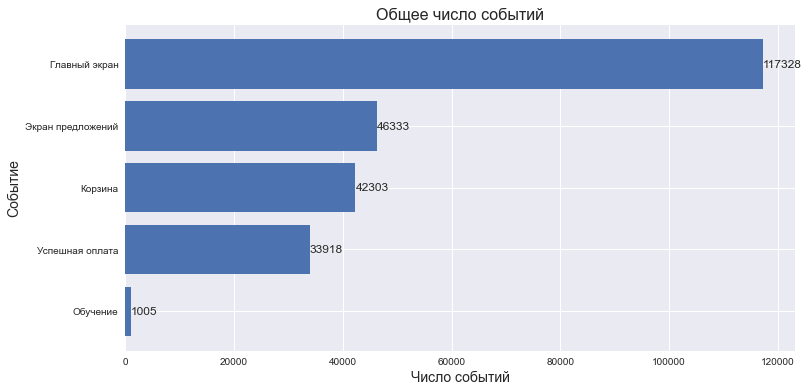

In [29]:
plot_events('event_cnt', 'Общее число событий', 'Число событий', '{}')

По общему числу событий предсказуемо лидирует заход на главный экран (почти 120 тыс. событий), затем с большим (примерно в три раза) отрывом следуют экран предложений, корзина и успешная оплата, причем разрывы между ними относительно невелики: примерно 25% между вторым и третьим местом. На последнем месте, также со значительным отставанием - обучение (встречается в 30 с лишним раз меньше, чем успешные покупки).

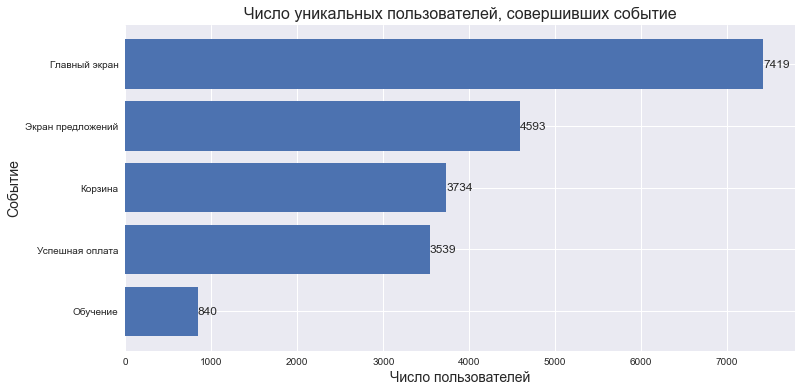

In [30]:
plot_events('user_cnt', 'Число уникальных пользователей, совершивших событие', 'Число пользователей', '{}')

Число уникальных пользователей, совершивших событие, распределяется схожим образом: большего всего пользователей заходят на главный экран, остальные шаги располагаются в той же последовательности, хотя относительная разница в численности здесь меньше.

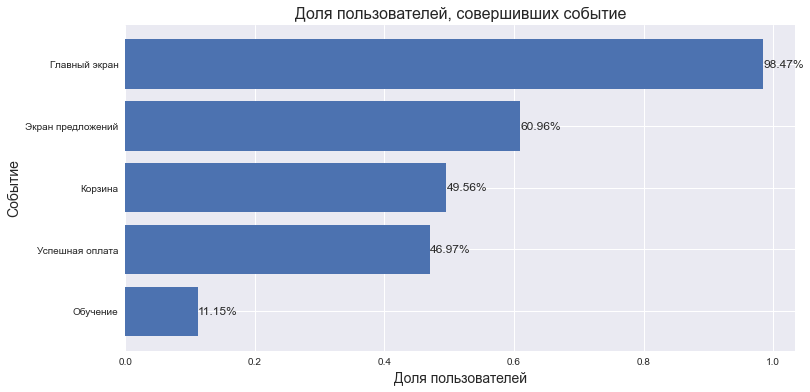

In [31]:
plot_events('user_share', 'Доля пользователей, совершивших событие', 'Доля пользователей', '{:.2%}')

На главный экран заходят 98.47% пользователей, что интересно, поскольку не очень понятно, откуда взялись остальные 1.5% пользователей (или их визит на главную не был записан?), около 60% пользователей добираются до экрана с предложениями, меньше 50% - до корзины и успешной оплаты, обучение пользуется наименьшей популярностью и привлекает около 11% пользователей.

В качестве промежуточного вывода можно заключить, что воронка состоит из четырех этапов, обучение в нее не входит, поскольку предполагается, очевидно, что оно должно заинтересовать новых пользователей и побудить их к покупках, однако число пользователей, прошедших обучение, гораздо меньше, чем число покупателей. Таким образом, обучение - это, скорее, исключительная девиация на основном пути, и рассматривать ее с точки зрения конверсии не следует. Рассчитаем конверсию на каждом из первых четырех этапов.

In [32]:
funnel = events[['event', 'user_cnt']][1:]\
                .sort_values('user_cnt', ascending=False)\
                .reset_index(drop=True)
funnel['conversion'] = np.round((funnel['user_cnt'][1:] / funnel['user_cnt'].shift(1)[1:]),
                                decimals=4) * 100

funnel

,event,user_cnt,conversion
0,Главный экран,7419,NaN
1,Экран предложений,4593,61.91
2,Корзина,3734,81.30
3,Успешная оплата,3539,94.78


Как видно, наихудшая конверсия у самого первого шага - от главного экрана к экрану предложений переходит чуть меньше 62% пользователей, далее, в корзину переходит больше 81% пользователей, а на последнем шаге конверсия самая высокая - почти 95%.

In [33]:
print(f'От главного экрана до оплаты доходят {funnel.iloc[3]["user_cnt"] / funnel.iloc[0]["user_cnt"]:.2%} пользователей')

От главного экрана до оплаты доходят 47.70% пользователей


### Вывод

1. Из пяти типов событий, которые попали в логи, четыре выстраиваются в последовательную цепочку: заход на главный экран, на экран предложений, в корзину и успешная оплата. Обучение не пользуется популярностью у пользователей, его проходят достаточно редко, и оно не является обязательным шагом на пути к покупке.
2. Наше приложение, по-видимому, используют достаточно мотивированные пользователи, так что 47.7% людей, заходящих в него (нужно обратить внимание на то, что заход на главный экран зафиксирован не для всех пользователей), доходят до покупки. Наихудшая конверсия наблюдается на переходе с главного экрана на экран предложений (здесь мы теряем почти 40% пользователей), далее, на переходе в корзину, мы теряем чуть меньше 20% пользователей. Наконец, 95% пользователей, перешедших в корзину, успешно завершают покупку.

[Наверх](#contents)

## 4. Анализ результатов A/A/B-эксперимента <a id='aab'></a>  

В данных есть сведения о трех группах: двух контрольных (им не показывали новый шрифт) и одной тестовой, которая видела новый шрифт. Мы будем сравнивать доли - какая часть пользователей из определенной группы совершает то или иное событие, - поэтому применим серию z-тестов с критическим уровнем значимости равным 0.05. Общий план исследования результатов эксперимента такой:
1. Рассчитать для каждой группы количество пользователей, совершивших каждое действие.
2. Сравнить между собой две контрольные выборки, чтобы убедиться в корректности дизайна эксперимента (ожидается, что значимых различий между этими двумя группами нет).
3. Сравнить каждую группу A и группу B.
4. Сравнить объединенную группу A и группу B. Несмотря на разницу в численности, такое сравнение возможно, так как обе группы достаточно большие.

In [34]:
aab_data = df_good.pivot_table(index='event', columns='group', values='uid', aggfunc='nunique')\
                    .sort_values('A1', ascending=False)
aab_data.rename(index=event_dct, inplace=True)
aab_data.loc['Всего', :] = df_good.groupby('group').agg({'uid': 'nunique'}).transpose().values
aab_data['A'] = aab_data['A1'] + aab_data['A2']
aab_data = aab_data.astype(int)

In [35]:
aab_data

group,A1,A2,B,A
event,,,,
Главный экран,2450,2476,2493,4926
Экран предложений,1542,1520,1531,3062
Корзина,1266,1238,1230,2504
Успешная оплата,1200,1158,1181,2358
Обучение,278,283,279,561
Всего,2484,2513,2537,4997


Мы получили таблицу, в которой для каждой выборки рассчитано число пользователей на каждом событии, а также общее число пользователей. Как уже отмечалось, выборки близки по размеру - в каждой примерно по 2500 человек, чего достаточно для проведения корректного статистического теста.

Для оптимизации расчетов создадим функцию для проведения теста.

In [36]:
def z_test(group1, group2, event, alpha=0.05):
    total = np.array([aab_data.loc['Всего'][group1], aab_data.loc['Всего'][group2]])
    events = np.array([aab_data.loc[event][group1], aab_data.loc[event][group2]])
    
    # доли по группам, доля по комбинированной выборке, разница долей по группам
    p1 = events[0] / total[0]
    p2 = events[1] / total[1]
    p_comb = np.sum(events) / np.sum(total)
    diff = abs(p1 - p2)
    
    # z-статистика
    z_value = diff / np.sqrt(p_comb * (1 - p_comb) * (1 / total[0] + 1 / total[1]))
    
    # p-value
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(z_value)) * 2
    
    print(f'Результаты z-теста для выборок {group1} и {group2} и события "{event}"')
    print(f'\tz-статистика: {z_value}')
    print(f'\tp-значение: {p_value}')
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу\n\n')
    else:
        print('Не удалось отвергнуть нулевую гипотезу\n\n')
        
    return z_value, p_value

### A. Сравнение контрольных выборок <a id='aa'></a>

Задача сравнения контрольных выборок - убедиться, что эксперимент поставлен корректно, то есть мы ожидаем, что различий между ними нет. Сравним их по доле пользователей, совершивших каждое из пяти событий. Нулевая гипотеза: статистически значимых различий между долями пользователей в двух выборках нет. Альтернативная гипотеза: выборки значимо отличаются.

In [37]:
for event in aab_data.index[:-1]:
    z_test('A1', 'A2', event)

Результаты z-теста для выборок A1 и A2 и события "Главный экран"
	z-статистика: 0.3093441851418436
	p-значение: 0.7570597232046099
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A1 и A2 и события "Экран предложений"
	z-статистика: 1.154987713610383
	p-значение: 0.2480954578522181
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A1 и A2 и события "Корзина"
	z-статистика: 1.203368576486285
	p-значение: 0.22883372237997213
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A1 и A2 и события "Успешная оплата"
	z-статистика: 1.5779948491596598
	p-значение: 0.11456679313141849
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A1 и A2 и события "Обучение"
	z-статистика: 0.0781614596617372
	p-значение: 0.9376996189257114
Не удалось отвергнуть нулевую гипотезу




Как и ожидалось, ни в одном из пяти тестов мы не нашли статистически значимых различий между двумя контрольными выборками. Таким образом, можно утверждать, что разбиение на группы было корректным и мы можем на основании имеющихся данных сравнить тестовую выборку с контрольными группами.

### B. Сравнение тестовой и контрольных групп <a id='ab'></a>

Сравнение тестовой и контрольных групп должно дать основания для выводов об эффективности эксперимента. Сравним их также по доле пользователей, совершивших каждое из пяти событий. Нулевая гипотеза: статистически значимых различий между долями пользователей в двух выборках нет. Альтернативная гипотеза: выборки значимо отличаются.

In [38]:
for event in aab_data.index[:-1]:
    z_test('A1', 'B', event)

Результаты z-теста для выборок A1 и B и события "Главный экран"
	z-статистика: 1.0472762353383693
	p-значение: 0.2949721933554552
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A1 и B и события "Экран предложений"
	z-статистика: 1.2580821335711887
	p-значение: 0.20836205402738917
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A1 и B и события "Корзина"
	z-статистика: 1.7598736474548398
	p-значение: 0.07842923237520116
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A1 и B и события "Успешная оплата"
	z-статистика: 1.2473878277158326
	p-значение: 0.2122553275697796
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A1 и B и события "Обучение"
	z-статистика: 0.21928326020412683
	p-значение: 0.8264294010087645
Не удалось отвергнуть нулевую гипотезу




Статистически значимых различий между двумя группами не обнаружено.

In [39]:
for event in aab_data.index[:-1]:
    z_test('A2', 'B', event)

Результаты z-теста для выборок A2 и B и события "Главный экран"
	z-статистика: 0.740980338642352
	p-значение: 0.4587053616621515
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A2 и B и события "Экран предложений"
	z-статистика: 0.1007086015299871
	p-значение: 0.9197817830592261
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A2 и B и события "Корзина"
	z-статистика: 0.5554019078073092
	p-значение: 0.5786197879539783
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A2 и B и события "Успешная оплата"
	z-статистика: 0.3353759529753951
	p-значение: 0.7373415053803964
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A2 и B и события "Обучение"
	z-статистика: 0.2984969253006019
	p-значение: 0.765323922474501
Не удалось отвергнуть нулевую гипотезу




Статистически значимых различий между двумя группами не обнаружено.

In [40]:
for event in aab_data.index[:-1]:
    z_test('A', 'B', event)

Результаты z-теста для выборок A и B и события "Главный экран"
	z-статистика: 1.048854111361149
	p-значение: 0.29424526837179577
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A и B и события "Экран предложений"
	z-статистика: 0.7819303684733905
	p-значение: 0.43425549655188256
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A и B и события "Корзина"
	z-статистика: 1.3353593793146474
	p-значение: 0.18175875284404386
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A и B и события "Успешная оплата"
	z-статистика: 0.5237830725856985
	p-значение: 0.6004294282308704
Не удалось отвергнуть нулевую гипотезу


Результаты z-теста для выборок A и B и события "Обучение"
	z-статистика: 0.2991016694401563
	p-значение: 0.764862472531507
Не удалось отвергнуть нулевую гипотезу




Статистически значимых различий между двумя группами не обнаружено.

### Вывод

По результатам 15 тестов, выявить статистически значимые различия между группами A1, A2 и B ни по одному событию не удалось. Следует особо заметить, что, несмотря на большое количество тестов, мы не применяли поправки на множественное сравнение (поправку Бонферрони, метода Холма-Бонферрони или другие), поскольку они призваны уменьшить вероятность ошибки первого рода (то есть шанс ложно отклонить нулевую гипотезу), о которой в нашем случае речь не идет. Таким образом, мы можем утверждать, что, по результатам эксперимента, нововведение (шрифт) не повлияло на поведение пользователей ни в положительную, ни в отрицательную сторону.

[Наверх](#contents)

## 5. Общий вывод <a id='conclusion'></a>

1. Проведенное исследование мобильного приложения стартапа, продающего продукты питания, основывалось на логах за первую неделю (с 1 по 8) августа 2019 года, в которых зафиксированы около 240 тысяч событий и 7500 уникальных пользователей (в среднем 32 события на одного пользователя).
2. Из пяти типов событий, которые попали в логи, четыре выстраиваются в последовательную воронку: заход на главный экран, на экран предложений, в корзину и, наконец, успешная оплата. Имеющееся кроме них обучение  проходят достаточно редко, оно не является обязательным шагом на пути к покупке.
3. Всего 47.7% людей, заходящих в него (нужно обратить внимание на то, что заход на главный экран зафиксирован не для всех, а примерно для 98.5% пользователей), доходят до покупки. Наихудшая конверсия наблюдается на переходе с главного экрана на экран предложений (61.8%), далее, на переходе в корзину, - 81.3% . Наконец, 94.8% пользователей, перешедших в корзину, успешно завершают покупку.
4. Цифры, приведенные в п. 3, показывают, что в основном у нас достаточно мотивированные пользователи, что в целом логично, так как если пользователь ставит себе приложение, единственная функция которого - магазин еды, то, вероятно, он предполагает что-то купить. В связи с этим следует подробнее изучить поведение пользователей на переходе от главного экрана к экрану предложений: получается, что почти 40% пользователей, скачавших приложение-магазин, не посмотрели, что оно, собственно, продает. Возможно, показатели на этом этапе можно улучшить.
5. Кроме изучения воронки, было проведено исследование результатов A/A/B-эксперимента, в котором проверялось, как изменение шрифта в приложении влияет на поведение пользователей. В результате последовательного сравнения долей уникальных пользователей в каждой группе на каждом событии не удалось выявить статистически значимые различия между тестовой и контрольными группами, таким образом, эксперимент показал, что такое изменение шрифта не влияет на поведение пользователей ни в лучшую, ни в худшую сторону.

[Наверх](#contents)